In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = 200

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from sklearn.linear_model import Lasso
from sklearn.tree import export_text, plot_tree
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    log_loss,
)
import xgboost as xgb

# 00.EDA

In [ ]:
PATH = "./dataproject2025.csv"
df = pd.read_csv(PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())
display(df.info())
display(df.isnull().sum().sort_values(ascending=False).head(30))

if "DP" in df.columns:
    print("DP distribution:")
    display(df["DP"].describe())
else:
    print("No DP column found — vérifie le nom exact dans le fichier de description.")

Shape: (734421, 39)
Columns: ['Unnamed: 0', 'issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'fico_range_high', 'funded_amnt', 'grade', 'home_ownership', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'target', 'tax_liens', 'zip_code', 'Pct_afro_american', 'Predictions', 'Predicted probabilities']


,Unnamed: 0,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,emp_title,fico_range_high,funded_amnt,grade,home_ownership,inq_last_6mths,int_rate,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_actv_bc_tl,num_bc_tl,num_il_tl,num_rev_accts,open_acc,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american,Predictions,Predicted probabilities
0,0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,other,759.0,4800.0,B,MORTGAGE,2.0,10.99,220.0,25.0,25.0,0.0,25.0,2.0,4.0,1.0,7.0,3.0,0.0,0.0,home_improvement,4136.0,16.1,B2,0.0,0.0,782.0,7.388592,0.0,0.053051
1,1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,other,734.0,27050.0,B,OWN,0.0,10.99,326.0,16.0,6.0,4.0,16.0,2.0,8.0,8.0,15.0,14.0,0.0,0.0,debt_consolidation,36638.0,61.2,B2,0.0,0.0,481.0,9.745456,0.0,0.084507
2,2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,sales manager,749.0,28000.0,A,MORTGAGE,1.0,7.62,229.0,5.0,2.0,5.0,5.0,4.0,8.0,11.0,15.0,15.0,0.0,0.0,debt_consolidation,29581.0,54.6,A3,0.0,0.0,945.0,7.542862,0.0,0.037206
3,3,2013,0,130000.0,36362.0,3567.0,93.0,0.0,13.03,10+ years,other,719.0,12000.0,B,MORTGAGE,1.0,11.99,193.0,4.0,4.0,3.0,85.0,3.0,4.0,8.0,8.0,9.0,0.0,0.0,debt_consolidation,10805.0,67.0,B3,0.0,0.0,809.0,6.598132,0.0,0.061371
4,4,2013,1,73000.0,24161.0,4853.0,74.7,1.0,23.13,6 years,other,669.0,27600.0,D,MORTGAGE,1.0,19.97,294.0,4.0,4.0,4.0,4.0,5.0,11.0,4.0,16.0,10.0,0.0,0.0,debt_consolidation,27003.0,82.8,D5,1.0,0.0,802.0,7.058900,1.0,0.345896


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734421 entries, 0 to 734420
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               734421 non-null  int64  
 1   issue_d                  734421 non-null  int64  
 2   loan duration            734421 non-null  int64  
 3   annual_inc               734421 non-null  float64
 4   avg_cur_bal              734421 non-null  float64
 5   bc_open_to_buy           734421 non-null  float64
 6   bc_util                  734421 non-null  float64
 7   delinq_2yrs              734421 non-null  float64
 8   dti                      734421 non-null  float64
 9   emp_length               734421 non-null  object 
 10  emp_title                734421 non-null  object 
 11  fico_range_high          734421 non-null  float64
 12  funded_amnt              734421 non-null  float64
 13  grade                    734421 non-null  object 
 14  home

None

Predicted probabilities    1
tax_liens                  1
revol_util                 1
sub_grade                  1
target                     1
revol_bal                  1
zip_code                   1
Pct_afro_american          1
Predictions                1
mort_acc                   0
purpose                    0
pub_rec_bankruptcies       0
pub_rec                    0
open_acc                   0
num_rev_accts              0
num_il_tl                  0
num_bc_tl                  0
num_actv_bc_tl             0
mths_since_recent_bc       0
Unnamed: 0                 0
issue_d                    0
emp_length                 0
loan duration              0
annual_inc                 0
avg_cur_bal                0
bc_open_to_buy             0
bc_util                    0
delinq_2yrs                0
dti                        0
emp_title                  0
dtype: int64

No DP column found — vérifie le nom exact dans le fichier de description.


# 01.First Surrogates

In [11]:
df_clean = df.dropna(subset=["Predicted probabilities"])
df_clean = df_clean.dropna()


print("Nb total:", len(df), " / Nb sans NaN:", len(df_clean))


y = df_clean["Predicted probabilities"]
X = df_clean.drop(columns=["Predicted probabilities", "Predictions", "target"])


X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=None, test_size=0.2, random_state=42
)

# Surrogate 1: shallow tree
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print("Tree R2 (fidelity to DP):", r2_score(y_test, pred_tree))

# Surrogate 2: linear regression
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(X_train, y_train)
pred_lin = lin.predict(X_test)
print("Linear R2 (fidelity to DP):", r2_score(y_test, pred_lin))

Nb total: 734421  / Nb sans NaN: 734420
Tree R2 (fidelity to DP): 0.7430558812604986
Linear R2 (fidelity to DP): 0.9661490300821293


The R2 indicates that our surrogates approximate pretty well the default blackbox model.

Let's try to do an interpretation analysis thanks to our surrogates for first conclusions:

|--- int_rate <= 14.39
|   |--- int_rate <= 11.18
|   |   |--- grade_B <= 0.50
|   |   |   |--- value: [0.06]
|   |   |--- grade_B >  0.50
|   |   |   |--- value: [0.11]
|   |--- int_rate >  11.18
|   |   |--- grade_B <= 0.50
|   |   |   |--- value: [0.20]
|   |   |--- grade_B >  0.50
|   |   |   |--- value: [0.14]
|--- int_rate >  14.39
|   |--- loan duration <= 0.50
|   |   |--- int_rate <= 17.82
|   |   |   |--- value: [0.22]
|   |   |--- int_rate >  17.82
|   |   |   |--- value: [0.29]
|   |--- loan duration >  0.50
|   |   |--- int_rate <= 17.82
|   |   |   |--- value: [0.30]
|   |   |--- int_rate >  17.82
|   |   |   |--- value: [0.41]



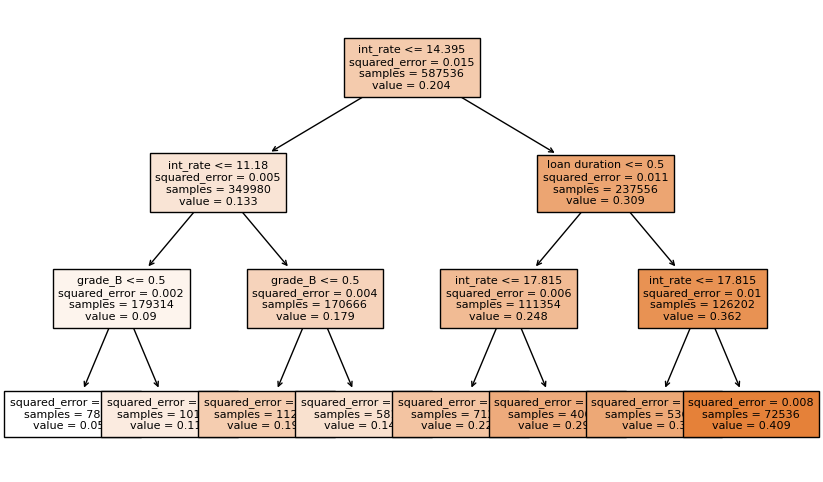

In [14]:
rules = export_text(tree, feature_names=list(X.columns))
print(rules)

plt.figure(figsize=(10, 6))
plot_tree(tree, feature_names=X.columns, filled=True, max_depth=3, fontsize=8)
plt.show()

In [15]:
coefs = pd.Series(lin.coef_, index=X.columns)
coefs_sorted = coefs.sort_values(key=np.abs, ascending=False)
print(coefs_sorted.head(10))

grade_G                   0.251353
grade_F                   0.215596
grade_E                   0.169771
grade_D                   0.118126
purpose_wedding          -0.091559
sub_grade_G5              0.086094
loan duration             0.083821
sub_grade_G4              0.083696
emp_title_associate      -0.079296
emp_title_truck driver    0.071447
dtype: float64


# 02.Our Blackbox Model

In [19]:
drop_cols = [
    c for c in ["Predicted probabilities", "Predictions"] if c in df_clean.columns
]
y = df_clean["target"].astype(int)
X = df_clean.drop(columns=["target"] + drop_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

num_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False)),
    ]
)

cat_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preproc = ColumnTransformer(
    [
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ]
)

xgb_model = xgb.XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    reg_alpha=0.0,
    min_child_weight=1,
    objective="binary:logistic",
    tree_method="hist",
    eval_metric="logloss",
    random_state=42,
)

pipe = Pipeline(
    [
        ("preproc", preproc),
        ("model", xgb_model),
    ]
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_validate(
    pipe,
    X,
    y,
    cv=cv,
    scoring={"AUC": "roc_auc", "AP": "average_precision"},
    n_jobs=-1,
    return_estimator=False,
)
print(
    f"[CV] AUC  : {cv_scores['test_AUC'].mean():.4f} ± {cv_scores['test_AUC'].std():.4f}"
)
print(
    f"[CV] PR-AU: {cv_scores['test_AP'].mean():.4f} ± {cv_scores['test_AP'].std():.4f}"
)

pipe.fit(X_train, y_train)
proba_test = pipe.predict_proba(X_test)[:, 1]

print(f"[TEST] AUC:    {roc_auc_score(y_test, proba_test):.4f}")
print(f"[TEST] PR-AUC: {average_precision_score(y_test, proba_test):.4f}")
print(f"[TEST] Brier:  {brier_score_loss(y_test, proba_test):.4f}")
print(f"[TEST] LogLoss:{log_loss(y_test, proba_test):.4f}")

[CV] AUC  : 0.7213 ± 0.0015
[CV] PR-AU: 0.3978 ± 0.0016
[TEST] AUC:    0.7223
[TEST] PR-AUC: 0.3988
[TEST] Brier:  0.1448
[TEST] LogLoss:0.4525
